Data from here: http://archive.ics.uci.edu/ml/datasets/online+retail#

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import os

## explore

In [3]:
raw = pd.read_excel('online_retail.xlsx')
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
raw.shape

(541909, 8)

In [5]:
raw['CustomerID'].unique().shape[0]/raw.shape[0]

0.008069620545146879

In [6]:
raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
raw['Description'].unique().shape[0]/raw.shape[0]

0.0077946666322205385

In [8]:
raw[raw['Description'] == 'WHITE METAL LANTERN'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
67,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
279,536396,71053,WHITE METAL LANTERN,6,2010-12-01 10:51:00,3.39,17850.0,United Kingdom
417,536406,71053,WHITE METAL LANTERN,8,2010-12-01 11:33:00,3.39,17850.0,United Kingdom


In [9]:
raw.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [10]:
np.amin(raw['InvoiceDate'])

Timestamp('2010-12-01 08:26:00')

In [11]:
np.amax(raw['InvoiceDate'])

Timestamp('2011-12-09 12:50:00')

In [12]:
raw['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

## build rankings matrix

should this be the spec?:

|user|countryonehot|item1|item2|...|itemN|
|---|---|---|---|
|user1|cntry|numItem1|numItem2|...|numItemN|
|user2|cntry|numItem1|numItem2|...|numItemN|
|.|.|.|.|...|.|
|.|.|.|.|...|.|
|.|.|.|.|...|.|
|userM|cntry|numItem1|numItem2|...|numItemN|

In [13]:
rankings_matrix = raw.groupby(['CustomerID','StockCode']).count()['InvoiceNo'].unstack()
rankings_matrix.reset_index(inplace=True)
rankings_matrix.head()

StockCode,CustomerID,10002,10080,10120,10125,10133,10135,11001,15030,15034,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
0,12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [14]:
rankings_matrix.shape

(4372, 3685)

In [15]:
customers = raw['CustomerID'].unique()
customers = np.delete(customers, 32)
countries = []

for i in customers:
    countries.append(raw[raw['CustomerID'] == i].iloc[0]['Country'])
    
countries = np.array(countries)

new = pd.DataFrame()
new['CustomerID'] = customers
new['Country'] = countries
new.head()

,CustomerID,Country
0,17850.0,United Kingdom
1,13047.0,United Kingdom
2,12583.0,France
3,13748.0,United Kingdom
4,15100.0,United Kingdom


In [16]:
rankings_matrix = rankings_matrix.merge(new, how='left', on='CustomerID')
rankings_matrix.fillna(value=0., inplace=True)
rankings_matrix.head()

,CustomerID,10002,10080,10120,10125,10133,10135,11001,15030,15034,...,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST,Country
0,12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,United Kingdom
1,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
2,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Finland
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy
4,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Norway


In [17]:
rankings_matrix = pd.get_dummies(rankings_matrix, columns=['Country'])
rankings_matrix.head()

,CustomerID,10002,10080,10120,10125,10133,10135,11001,15030,15034,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
temp = rankings_matrix.drop(['CustomerID'], axis=1)

nonz = np.flatnonzero(temp.as_matrix())

print('sparsity = ', 100 * nonz.shape[0] / (temp.shape[0] * temp.shape[1]), '%')

sparsity =  1.6718923997302224 %


In [19]:
rankings_matrix.to_csv('rankings.csv', index=False)

## cluster

In [20]:
km = KMeans(n_clusters=20, n_init=50, n_jobs=-1)

In [21]:
%%time

km.fit(rankings_matrix)

rankings_matrix['cluster'] = km.labels_

os.system("spd-say 'Your calculations are complete.' -r -50 -t female3")

CPU times: user 8.91 s, sys: 198 ms, total: 9.11 s
Wall time: 45.1 s


In [22]:
rankings_matrix.groupby('cluster').count().describe()['CustomerID']

count     20.000000
mean     218.600000
std       12.934654
min      193.000000
25%      212.500000
50%      216.500000
75%      227.500000
max      242.000000
Name: CustomerID, dtype: float64

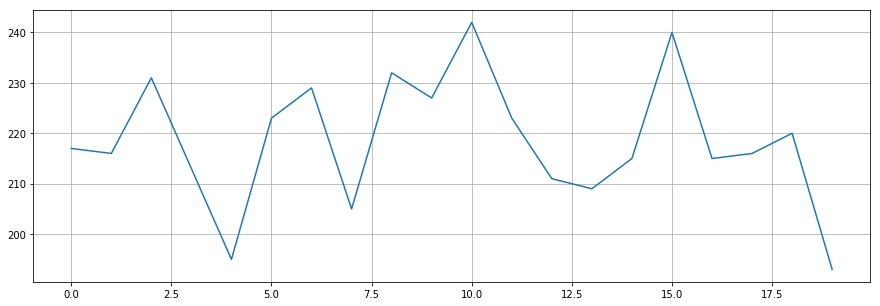

In [23]:
cluster_counts = list(rankings_matrix.groupby('cluster').count()['CustomerID'])

plt.figure(figsize=(15,5))

plt.plot(range(len(cluster_counts)), cluster_counts)

plt.grid()
plt.show()

In [24]:
rankings_matrix.head()

,CustomerID,10002,10080,10120,10125,10133,10135,11001,15030,15034,...,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,cluster
0,12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,11
1,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,11
2,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,11
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,11
4,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,11


## covariance

In [25]:
vals = rankings_matrix.drop(['cluster', 'CustomerID'], inplace=False, axis=1)

vals.shape

(4372, 3721)

In [26]:
# users
#cov = np.cov(vals)

# items
cov = np.cov(np.transpose(vals))

cov.shape

(3721, 3721)

In [27]:
print('mean:', np.mean(cov))
print('std:', np.std(cov))
print('max: ', np.amax(cov))
print('min: ', np.amin(cov))

mean: 0.0039031972421167786
std: 0.01411199133882789
max:  2.385481442921125
min:  -0.22753559757053027


In [28]:
temp = cov

temp = abs(temp)

#super_threshold_indices = temp > .1
#temp[super_threshold_indices] = 0

temp = normalize(temp)

print('mean:', np.mean(temp))
print('std:', np.std(temp))
print('max: ', np.amax(temp))
print('min: ', np.amin(temp))

mean: 0.0077318626939713005
std: 0.0144555615703284
max:  0.7512209310916179
min:  1.8614878607810007e-08


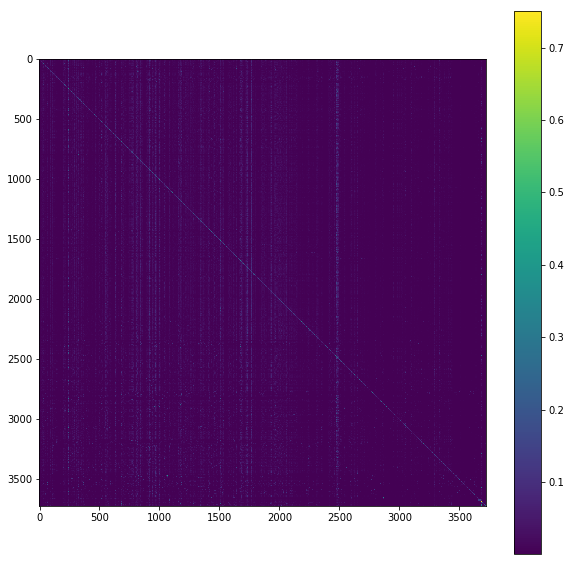

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(temp, cmap='viridis')
plt.colorbar()
plt.show()

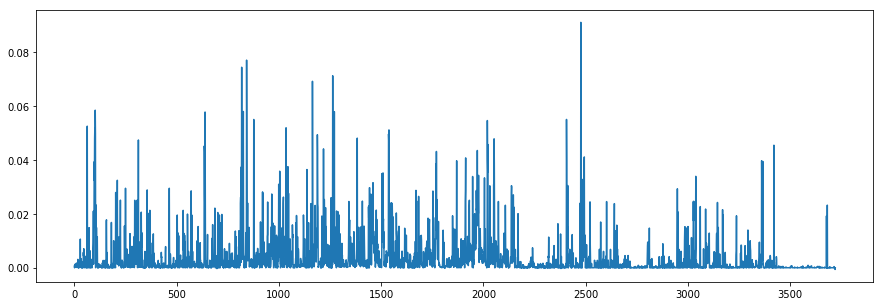

In [30]:
plt.figure(figsize=(15,5))

plt.plot(cov[3000])

plt.show()

## PCA viz

In [31]:
vals.shape

(4372, 3721)

In [32]:
%%time
pca = PCA(n_components=2)

# items
#components = pca.fit_transform(np.transpose(vals))

# users
components = pca.fit_transform(vals)
print(components.shape)

(4372, 2)
CPU times: user 921 ms, sys: 82.4 ms, total: 1 s
Wall time: 383 ms


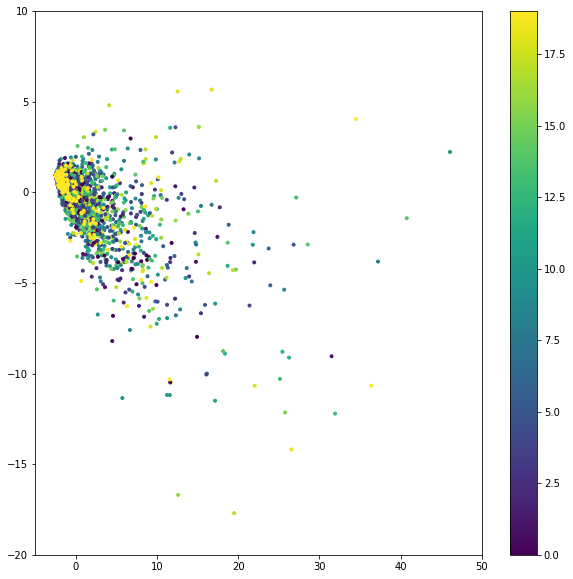

In [33]:
plt.figure(figsize=(10,10))

plt.scatter(components[:,0], components[:,1], c=rankings_matrix['cluster'], marker='.')
plt.xlim(-5,50)
plt.ylim(-20,10)

plt.colorbar()
plt.show()